# Переобучение и методы борьбы с ним (5 баллов)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

### Задание 1. Генерация данных (1 балл)
Сгенерируем искусственные данные из линейной зависимости с шумом, имеющим нормальное распределение.

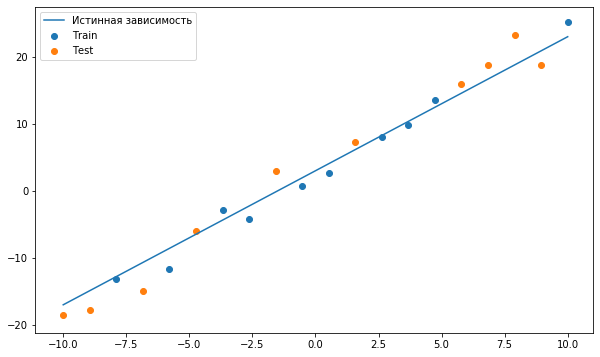

In [3]:
X = np.linspace(-10, 10, 20)

y = 2 * X + 3 + np.random.randn(20) * 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train, label='Train')
plt.scatter(X_test,y_test, label='Test')
plt.plot(X, 2 * X + 3, label='Истинная зависимость')
plt.legend()
plt.show()

### Задание 2. Обучение полиномиальной модели (1 балл)
Реализуйте функцию, которая принимает на вход обучающую выборку, а также степень искомого многочлена, который нужно построить. Функция возращает np.array коэффициентов искомого многочлена. Используйте функцию ``np.polyfit``.

In [4]:
def get_polynom(X, y, deg):
    return np.polyfit(X, y, deg)

Реализуйте функцию, которая принимает на вход выборку ``X``, вектор правильных ответов ``y`` и многочлен ``poly``, и вычисляет значение MSE между ``poly(X)`` и ``y``.

In [16]:
from sklearn.metrics import mean_squared_error

def get_mse(X, y, poly):
    return mean_squared_error(y, np.poly1d(poly)(X))

Протестируем функции, которые вы написали. Построим графики получившихся многочленов и вычислим средние квадратические ошибки на train и test.
### Задание 3. Заполните пропуски в построении графиков (2 балла)

C:\Users\lex\anaconda33\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


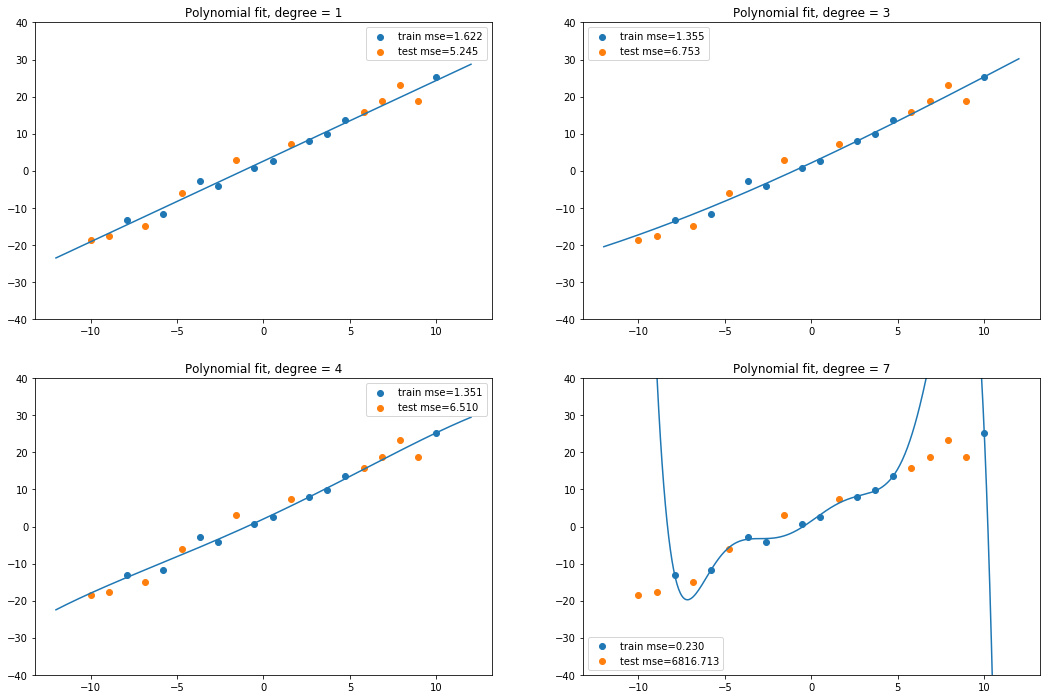

In [17]:
#сетка для отображения графика на отрезке [-12, 12] из 500 элементов
grid = np.linspace(-12, 12, 500) 

fig, ax = plt.subplots(2, 2, figsize=(18,12))

ax = ax.ravel()

for i, deg in enumerate([1,3,4,7]):
    poly = get_polynom(X_train, y_train, deg) #Ваш код: восстановите полином по значениям X_train и y_train
    train_mse = get_mse(X_train, y_train, poly) #Ваш код: вычислите mse на обучающей выборке
    test_mse = get_mse(X_test, y_test, poly) #Ваш код: вычислите mse на тестовой выборке
    
    
    ax[i].scatter(X_train,y_train, 
                  label='train mse={:.3f}'.format(train_mse))
    ax[i].scatter(X_test,y_test, 
                  label='test mse={:.3f}'.format(test_mse))
    ax[i].plot(grid, np.poly1d(poly)(grid))
    
    
    
    ax[i].set_title('Polynomial fit, degree = ' + str(deg))
    ax[i].set_ylim(-40, 40)
    ax[i].legend()
fig.show()

### Задание 4. Выводы (1 балл)

Сделайте выводы. Имеет ли место переобучение в данной модели? Как падение качества зависит от степени многочлена?

**Мы наблюдаем переобучение - на тестовой выборке ошибка модели возрастает пропроционально росту степеней свободы модели (степени многочлена)**

# Композиции алгоритмов: стекинг (5 баллов)
Это домашнее задание является продолжением ноутбука, с которым мы работали на практическом занятиии по выбору модели. В этом ноутбуке вам предстоит построить композицию алгоритмов на основе стекинга.

Первую часть ноутбука с семинара мы скопировали за вас.

## Код с семинара
Обработка набора данных, выделение признаков, формирование матрицы объекты-признаки

In [19]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам, как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1 (True), если зарплата больше 50K, 0 (False) иначе

In [20]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


In [21]:
dummy_features = pd.get_dummies(categorial_data)

In [22]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Выделим целевую переменную в y и вычислим процент единиц в значениях y.

In [23]:
y = df['salary']
y.mean()

0.24081695331695332

Видим, что обучающая выборка не сбалансированная. Поэтому для оценки качества предсказания метрика accuracy (процент верно угаданных лейблов) не подойдёт. Вместо этого будем использовать метрику F1-score (https://en.wikipedia.org/wiki/F1_score).

F1-score --- метрика, которая учитывает возможную разбалансировку классов при решении задачи классификации. Она вычисляется по формуле 
$${\displaystyle F_{1}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}},$$

где $$\mathrm{precision} = \frac{\mathrm{True Positive}}{\mathrm{True Positive} + \mathrm{False Positive}}, \,\,\,\, \mathrm{recall} = \frac{\mathrm{True Positive}}{\mathrm{True Positive} + \mathrm{False Negative}}.$$

<img src="https://drive.google.com/uc?id=1y2t9uW5mvEdlUt6jXITbr6WW1fr8YpKS" style="width:350px;height:660px"/>

### Разбиение данных на train и test

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Задание 4. Модель с семинара (0 баллов)
Воспроизведите модель с семинара, которая дала наилучшее качество (кроме бустинга). Можно просто скопировать нужный код из семинара. Не забудьте посчитать качество

## Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов. 

<img src='https://drive.google.com/uc?id=14SYhjGMb_onpGV2SjJBydlPpmRRJ_xSd' width=500/>

В качестве метаалгоритма $m$, принимающего на вход в качестве признаков значения первичных моделей, можно выбирать логистическую регрессию или, скажем, решающее дерево.

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

In [27]:
from sklearn.model_selection import cross_val_predict

In [28]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

### Задание 5. Первичные модели (2 балла)
Создайте несколько разноплановых моделей, которые в семинаре дали наилучший результат. Не забудьте, например, про логистическую регрессию, которой не было в семинаре. 

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
models = [DecisionTreeClassifier(), LogisticRegression(max_iter=1000), RandomForestClassifier(n_estimators=75, n_jobs=-1)]

Вычислим мета-признаки для созданных моделей.

In [44]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [45]:
for model in models:
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

### Задание 6. Создание метаалгоритма (1 балл)

Создайте модель для стекинга (например, логистическую регрессию или решающее дерево). Обучите модель на мета-признаках, которые вы вычислили. Предскажите целевую переменную с помощью stacking_model

In [46]:
stacking_model = LogisticRegression(max_iter=1000) #ВАШ КОД: заведите модель

#ВАШ КОД: обучите модель
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict(meta_features_train)
y_test_predicted = stacking_model.predict(meta_features_test)

### Задание 7. Качество модели стекинга (1 балл)
Вычислите качество полученной модели и сравните его с качеством, полученным с помощью лучшей модели с семинара кроме бустинга, и с помощью бустинга.

Постарайтесь превзойти качество, полученное моделью с семинара. 

In [47]:
from sklearn.metrics import f1_score
f1_score(y_test,y_test_predicted)

0.686556927297668

### Задание 8. Выводы (1 балл)
Опишите вашу итоговую модель стекинга и сравните результаты с другими построенными моделями.

Удалось ли с помощью стекинга побить качество, полученное на семинаре? Удалось ли превзойти градиентный бустинг?

**С помощью стекинга нескольких моделей (дерево решений, логистическая регрессия, случайный лес) нам удалось превзойти немного качество случайного леса в отдельности (f1=0.6782), но не удалось превзойти бустинг (f1=0.7081)**